# SVM with Dimensionality Reduction (PCA): From Scratch vs Library (Window Size = 14)

- Dataset: `CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv`
- Target: `Target_Return_7d` mapped to 3 classes
  - Uptrend: `> 0.03`
  - Downtrend: `< -0.03`
  - Sideway: otherwise
- Features: selected from `CLASSIFY-AMZN_methods_all_in_one.csv`
- Dimensionality Reduction: **PCA** (Principal Component Analysis)
- Models:
  1. SVM (from scratch via gradient descent, One-vs-Rest with hinge loss)
  2. SVM (scikit-learn SVC with RBF kernel)

Outputs:
- Loss
- Confusion matrix
- Accuracy
- Precision, Recall, Specificity (macro), F1-score
- ROC & AUC (multiclass, OvR)
- Performance curves (loss and accuracy)

Rows after cleaning: 4022
Number of features used: 9
Features used: ['ma_gap_20', 'vol_10', 'vol_20', 'lower_wick', 'upper_wick', 'ret_1', 'range_pct', 'co_ret', 'ret_5']

Target mapping:
  > 0.03 -> Uptrend (2)
  < -0.03 -> Downtrend (0)
  otherwise -> Sideway (1)
Class distribution: {'Downtrend': 784, 'Sideway': 2035, 'Uptrend': 1203}

=== PCA Dimensionality Reduction ===
Original features (after windowing): 126
Reduced components (95% variance): 59
Total explained variance: 0.9503


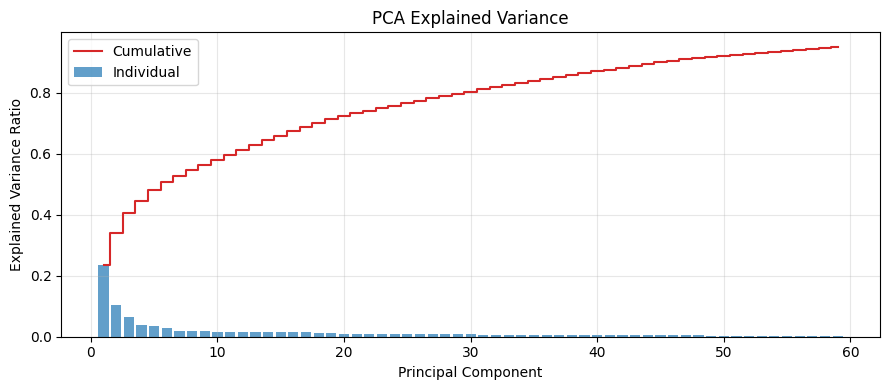

=== Loss ===
Scratch log loss: 1.089519
Library log loss: 1.029985

=== Confusion Matrix (rows=true, cols=pred) ===
Class order: ['Downtrend', 'Sideway', 'Uptrend']
Scratch:
 [[ 12 106  41]
 [ 11 305  79]
 [ 13 165  70]]
Library:
 [[  0 145  14]
 [  1 376  18]
 [  1 234  13]]

=== Per-Class Metrics (Scratch) ===
Downtrend  | Precision: 0.3333 | Recall: 0.0755 | F1: 0.1231 | Support: 159
Sideway    | Precision: 0.5295 | Recall: 0.7722 | F1: 0.6282 | Support: 395
Uptrend    | Precision: 0.3684 | Recall: 0.2823 | F1: 0.3196 | Support: 248

=== Per-Class Metrics (Library) ===
Downtrend  | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | Support: 159
Sideway    | Precision: 0.4980 | Recall: 0.9519 | F1: 0.6539 | Support: 395
Uptrend    | Precision: 0.2889 | Recall: 0.0524 | F1: 0.0887 | Support: 248

=== Metrics Summary (Macro) ===
Accuracy - Scratch: 0.4825 | Library: 0.4850
Precision - Scratch: 0.4104 | Library: 0.2623
Recall - Scratch: 0.3766 | Library: 0.3348
Specificity - Scratch: 0.6

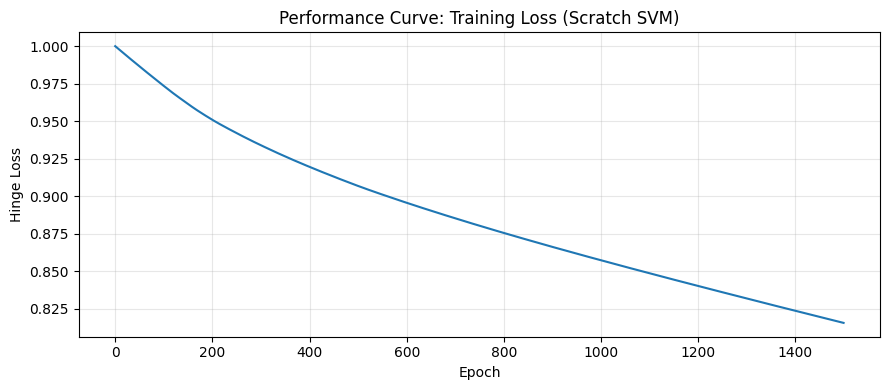

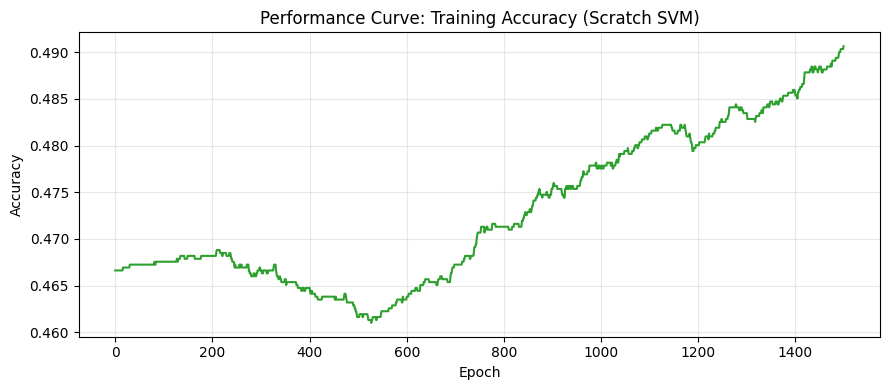

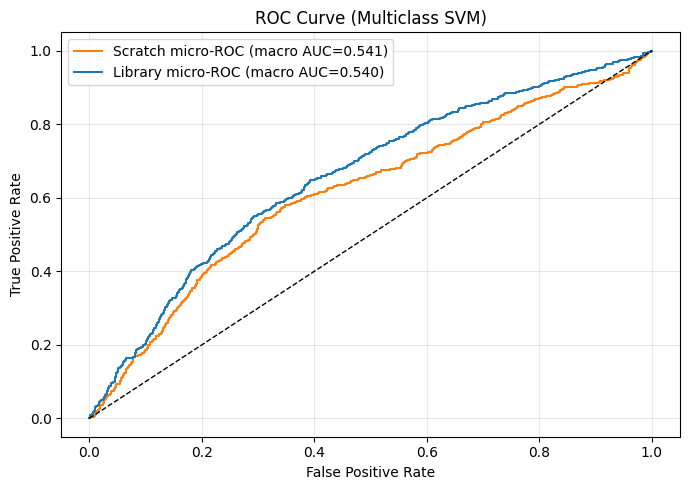

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

WINDOW_SIZE = 14
DATA_PATH = '../CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = '../CLASSIFY-AMZN_methods_all_in_one.csv'
TARGET_COL = 'Target_Return_7d'

# Thresholds for 3-class target mapping
UP_THRESHOLD = 0.03
DOWN_THRESHOLD = -0.03

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

requested_features = [
    'ma_gap_20', 'vol_10', 'vol_20',
    'lower_wick', 'upper_wick',
    'ret_1',
    'range_pct',
    'co_ret',
    'ret_5'
]
allowed_features = feature_df['feature'].tolist() if 'feature' in feature_df.columns else []
feature_cols = [c for c in requested_features if c in allowed_features and c in df.columns and c != TARGET_COL]
missing = [c for c in requested_features if c not in feature_cols]
if missing:
    print('Missing features:', missing)

# Basic cleaning and sorting (time series)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features used: {len(feature_cols)}')
print('Features used:', feature_cols)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.int64)

def map_target_3class(y_values, up_thr=0.03, down_thr=-0.03):
    y_cls = np.full_like(y_values, 1, dtype=np.int64)  # 1 = Sideway
    y_cls[y_values > up_thr] = 2                        # 2 = Up
    y_cls[y_values < down_thr] = 0                      # 0 = Down
    return y_cls

CLASS_LABELS = {0: 'Downtrend', 1: 'Sideway', 2: 'Uptrend'}

X_raw = model_df[feature_cols].values.astype(np.float64)
y_raw_cont = model_df[TARGET_COL].values.astype(np.float64)
y_raw = map_target_3class(y_raw_cont, up_thr=UP_THRESHOLD, down_thr=DOWN_THRESHOLD)

print('\nTarget mapping:')
print(f'  > {UP_THRESHOLD:.2f} -> Uptrend (2)')
print(f'  < {DOWN_THRESHOLD:.2f} -> Downtrend (0)')
print('  otherwise -> Sideway (1)')
print('Class distribution:', {CLASS_LABELS[k]: int((y_raw == k).sum()) for k in sorted(CLASS_LABELS)})

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

# Chronological split (80/20)
split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize by train statistics
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train_scaled = (X_train_raw - x_mean) / x_std
X_test_scaled = (X_test_raw - x_mean) / x_std

# -------------------------------------------------
# 3) Dimensionality Reduction with PCA
# -------------------------------------------------
# Keep 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

n_components = pca.n_components_
explained_var = pca.explained_variance_ratio_.sum()
print(f'\n=== PCA Dimensionality Reduction ===')
print(f'Original features (after windowing): {X_train_scaled.shape[1]}')
print(f'Reduced components (95% variance): {n_components}')
print(f'Total explained variance: {explained_var:.4f}')

# Plot explained variance
plt.figure(figsize=(9, 4))
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.7, label='Individual')
plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative', color='tab:red')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4) SVM from Scratch (Linear, One-vs-Rest, Hinge Loss + GD)
# --------------------------------------------------
class LinearSVMScratchOvR:
    """Multiclass linear SVM using One-vs-Rest with hinge loss and gradient descent."""
    def __init__(self, lr=0.001, C=1.0, epochs=1500):
        self.lr = lr
        self.C = C          # regularization parameter
        self.epochs = epochs
        self.models = {}    # per-class weights
        self.classes_ = None
        self.loss_history = []
        self.acc_history = []

    def _hinge_loss_grad(self, X, y_binary, W, b):
        """Compute hinge loss and gradients for one binary SVM."""
        n = X.shape[0]
        margins = y_binary * (X @ W + b)            # (n,)
        hinge = np.maximum(0, 1 - margins)           # (n,)
        loss = 0.5 * np.dot(W, W) + self.C * np.mean(hinge)

        mask = (margins < 1).astype(np.float64)      # violated samples
        dW = W - (self.C / n) * (X.T @ (mask * y_binary))
        db = -(self.C / n) * np.sum(mask * y_binary)
        return loss, dW, db

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape

        # Train one binary SVM per class
        for cls in self.classes_:
            y_bin = np.where(y == cls, 1.0, -1.0)
            W = np.zeros(n_features, dtype=np.float64)
            b = 0.0
            for _ in range(self.epochs):
                loss, dW, db = self._hinge_loss_grad(X, y_bin, W, b)
                W -= self.lr * dW
                b -= self.lr * db
            self.models[cls] = (W.copy(), b)

        # Record training loss and accuracy history over epochs (aggregate)
        self.loss_history = []
        self.acc_history = []
        temp_models = {cls: (np.zeros(n_features), 0.0) for cls in self.classes_}

        for epoch in range(self.epochs):
            total_loss = 0.0
            for cls in self.classes_:
                y_bin = np.where(y == cls, 1.0, -1.0)
                W, b_val = temp_models[cls]
                loss, dW, db = self._hinge_loss_grad(X, y_bin, W, b_val)
                W = W - self.lr * dW
                b_val = b_val - self.lr * db
                temp_models[cls] = (W.copy(), b_val)
                total_loss += loss
            self.loss_history.append(total_loss / len(self.classes_))

            # Compute training accuracy using current temp models
            scores = np.column_stack([X @ temp_models[c][0] + temp_models[c][1] for c in self.classes_])
            preds = self.classes_[np.argmax(scores, axis=1)]
            self.acc_history.append(np.mean(preds == y))

        # Store final trained models from the history run
        self.models = {cls: temp_models[cls] for cls in self.classes_}

    def decision_function(self, X):
        """Return raw decision scores for each class."""
        scores = np.column_stack([X @ self.models[c][0] + self.models[c][1] for c in self.classes_])
        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        return self.classes_[np.argmax(scores, axis=1)]

    def predict_proba(self, X):
        """Approximate probabilities via softmax on decision scores (for ROC/AUC)."""
        scores = self.decision_function(X)
        scores_stable = scores - np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores_stable)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


scratch_model = LinearSVMScratchOvR(lr=0.0005, C=1.0, epochs=1500)
scratch_model.fit(X_train, y_train)
y_prob_scratch = scratch_model.predict_proba(X_test)
y_pred_scratch = scratch_model.predict(X_test)

# -------------------------------------
# 5) SVM Library (scikit-learn SVC)
# -------------------------------------
lib_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
lib_model.fit(X_train, y_train)
y_prob_lib = lib_model.predict_proba(X_test)
y_pred_lib = lib_model.predict(X_test)

# ------------------------
# 6) Metrics and outputs
# ------------------------
classes = np.array([0, 1, 2])

loss_scratch = log_loss(y_test, y_prob_scratch, labels=classes)
loss_lib = log_loss(y_test, y_prob_lib, labels=classes)

cm_scratch = confusion_matrix(y_test, y_pred_scratch, labels=classes)
cm_lib = confusion_matrix(y_test, y_pred_lib, labels=classes)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
acc_lib = accuracy_score(y_test, y_pred_lib)

precision_scratch = precision_score(y_test, y_pred_scratch, average='macro', zero_division=0)
precision_lib = precision_score(y_test, y_pred_lib, average='macro', zero_division=0)

recall_scratch = recall_score(y_test, y_pred_scratch, average='macro', zero_division=0)
recall_lib = recall_score(y_test, y_pred_lib, average='macro', zero_division=0)

f1_scratch = f1_score(y_test, y_pred_scratch, average='macro', zero_division=0)
f1_lib = f1_score(y_test, y_pred_lib, average='macro', zero_division=0)

mse_scratch = mean_squared_error(y_test, y_pred_scratch)
mse_lib = mean_squared_error(y_test, y_pred_lib)
rmse_scratch = np.sqrt(mse_scratch)
rmse_lib = np.sqrt(mse_lib)
r2_scratch = r2_score(y_test, y_pred_scratch)
r2_lib = r2_score(y_test, y_pred_lib)

def multiclass_macro_specificity(cm):
    total = np.sum(cm)
    specs = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = total - (tp + fp + fn)
        specs.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
    return float(np.mean(specs))

specificity_scratch = multiclass_macro_specificity(cm_scratch)
specificity_lib = multiclass_macro_specificity(cm_lib)

print('=== Loss ===')
print(f'Scratch log loss: {loss_scratch:.6f}')
print(f'Library log loss: {loss_lib:.6f}')

print('\n=== Confusion Matrix (rows=true, cols=pred) ===')
print('Class order:', [CLASS_LABELS[c] for c in classes])
print('Scratch:\n', cm_scratch)
print('Library:\n', cm_lib)

p_s, r_s, f_s, sup_s = precision_recall_fscore_support(y_test, y_pred_scratch, labels=classes, zero_division=0)
p_l, r_l, f_l, sup_l = precision_recall_fscore_support(y_test, y_pred_lib, labels=classes, zero_division=0)

print('\n=== Per-Class Metrics (Scratch) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_s[i]:.4f} | Recall: {r_s[i]:.4f} | F1: {f_s[i]:.4f} | Support: {sup_s[i]}")

print('\n=== Per-Class Metrics (Library) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_l[i]:.4f} | Recall: {r_l[i]:.4f} | F1: {f_l[i]:.4f} | Support: {sup_l[i]}")

print('\n=== Metrics Summary (Macro) ===')
print(f'Accuracy - Scratch: {acc_scratch:.4f} | Library: {acc_lib:.4f}')
print(f'Precision - Scratch: {precision_scratch:.4f} | Library: {precision_lib:.4f}')
print(f'Recall - Scratch: {recall_scratch:.4f} | Library: {recall_lib:.4f}')
print(f'Specificity - Scratch: {specificity_scratch:.4f} | Library: {specificity_lib:.4f}')
print(f'F1-score - Scratch: {f1_scratch:.4f} | Library: {f1_lib:.4f}')

print('\n=== Additional Numeric Metrics (Label-Encoded) ===')
print(f'MSE - Scratch: {mse_scratch:.4f} | Library: {mse_lib:.4f}')
print(f'RMSE - Scratch: {rmse_scratch:.4f} | Library: {rmse_lib:.4f}')
print(f'R² - Scratch: {r2_scratch:.4f} | Library: {r2_lib:.4f}')

# ROC & AUC (multiclass OvR + micro-curve for plotting)
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc_s = roc_auc_score(y_test_bin, y_prob_scratch, average='macro', multi_class='ovr')
roc_auc_l = roc_auc_score(y_test_bin, y_prob_lib, average='macro', multi_class='ovr')

fpr_s, tpr_s, _ = roc_curve(y_test_bin.ravel(), y_prob_scratch.ravel())
fpr_l, tpr_l, _ = roc_curve(y_test_bin.ravel(), y_prob_lib.ravel())

print('\n=== ROC & AUC (Multiclass OvR Macro AUC) ===')
print(f'Scratch AUC: {roc_auc_s:.4f}')
print(f'Library AUC: {roc_auc_l:.4f}')

# ---------------------------------------------------------
# 7) Performance curves (loss + accuracy) and ROC
# ---------------------------------------------------------
# Performance curve: Loss (scratch)
plt.figure(figsize=(9, 4))
plt.plot(scratch_model.loss_history, color='tab:blue')
plt.title('Performance Curve: Training Loss (Scratch SVM)')
plt.xlabel('Epoch')
plt.ylabel('Hinge Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Performance curve: Accuracy (scratch)
plt.figure(figsize=(9, 4))
plt.plot(scratch_model.acc_history, color='tab:green')
plt.title('Performance Curve: Training Accuracy (Scratch SVM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ROC Curve (micro-averaged one-vs-rest)
plt.figure(figsize=(7, 5))
plt.plot(fpr_s, tpr_s, label=f'Scratch micro-ROC (macro AUC={roc_auc_s:.3f})', color='tab:orange')
plt.plot(fpr_l, tpr_l, label=f'Library micro-ROC (macro AUC={roc_auc_l:.3f})', color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curve (Multiclass SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()